# Understanding the Attention Mechanism

This notebook explores the core attention mechanism that powers transformer models. We'll build intuition about how attention works and implement it step by step.

## Why Do We Need Attention?

Imagine you're reading this sentence: "The bank by the river was closed because the bank couldn't process loans."

How do you know which "bank" refers to the financial institution vs. the riverside? Your brain automatically focuses on different context words:
- For the first "bank": you notice "river" → riverside bank
- For the second "bank": you notice "loans" → financial bank

This is exactly what **attention** does in neural networks - it helps the model focus on relevant context when processing each word.

## What is Attention?

Attention allows the model to focus on different parts of the input when making predictions. The key insight is that not all parts of the input are equally important for understanding a given word.

The attention mechanism computes a weighted sum of values, where the weights are determined by the similarity between queries and keys.

### The Restaurant Analogy 🍽️

Think of attention like a restaurant:
- **Queries (Q)**: "What does the customer want?"  
- **Keys (K)**: "What's on the menu?"
- **Values (V)**: "What's actually served"

The waiter (attention mechanism) matches customer desires (Q) with available options (K) to decide what to serve (V)!

# Understanding the Attention Mechanism

This notebook explores the core attention mechanism that powers transformer models. We'll build intuition about how attention works and implement it step by step.

## What is Attention?

Attention allows the model to focus on different parts of the input when making predictions. The key insight is that not all parts of the input are equally important for predicting a given output.

The attention mechanism computes a weighted sum of values, where the weights are determined by the similarity between queries and keys.


In [ ]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Building Attention Step by Step

Let's build the attention mechanism piece by piece to understand each component.

### Step 1: The Core Idea
We want to compute how much each word should "attend to" (focus on) every other word.

### Step 2: Measuring Similarity  
We measure similarity between words using **dot products**:
- Similar words → high dot product
- Dissimilar words → low dot product

### Step 3: From Similarity to Attention Weights
1. Compute similarity scores: `scores = query · key`
2. Scale to prevent extreme values: `scores = scores / √d_k`  
3. Convert to probabilities: `weights = softmax(scores)`
4. Use weights to combine values: `output = weights · values`

### The Complete Formula
This gives us the famous attention formula:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q$ are the queries (what we're looking for)
- $K$ are the keys (what's available to attend to)  
- $V$ are the values (what we actually use)
- $d_k$ is the dimension of the keys (for numerical stability)

**Why the scaling?** Without $\sqrt{d_k}$, dot products become very large, making softmax too sharp (almost one-hot). Scaling keeps things smooth.

Let's implement this step by step:

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None, show_steps=True):
    """
    Compute scaled dot-product attention with detailed explanations.
    
    Args:
        Q: Queries [batch_size, seq_len, d_k] - "what we're looking for"
        K: Keys [batch_size, seq_len, d_k] - "what's available"
        V: Values [batch_size, seq_len, d_v] - "what we actually use"
        mask: Optional mask [batch_size, seq_len, seq_len]
        show_steps: Whether to print intermediate steps
    
    Returns:
        output: [batch_size, seq_len, d_v] - attended representation
        attention_weights: [batch_size, seq_len, seq_len] - attention pattern
    """
    d_k = Q.size(-1)
    
    # STEP 1: Compute similarity scores
    # This measures "how well does each query match each key?"
    scores = torch.matmul(Q, K.transpose(-2, -1))  # [batch, seq, seq]
    if show_steps:
        print(f"📊 Step 1 - Raw similarity scores:")
        print(f"   Shape: {scores.shape}")
        print(f"   Range: [{scores.min():.3f}, {scores.max():.3f}]")
        print(f"   Interpretation: Higher = more similar")
    
    # STEP 2: Scale by sqrt(d_k) for numerical stability
    # Without this, softmax becomes too sharp (almost one-hot)
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    if show_steps:
        print(f"\n⚖️  Step 2 - Scaled scores (÷√{d_k}):")
        print(f"   Range: [{scores.min():.3f}, {scores.max():.3f}]")
        print(f"   Why scale? Prevents softmax saturation")
    
    # STEP 3: Apply mask if provided (for causal attention)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        if show_steps:
            print(f"\n🚫 Step 3 - Applied mask:")
            print(f"   Masked positions set to -∞ (will become 0 after softmax)")
    
    # STEP 4: Convert to attention weights using softmax
    # This ensures weights sum to 1 for each query
    attention_weights = F.softmax(scores, dim=-1)
    if show_steps:
        print(f"\n🎯 Step 4 - Attention weights (after softmax):")
        print(f"   Range: [{attention_weights.min():.3f}, {attention_weights.max():.3f}]")
        print(f"   Sum per row: {attention_weights.sum(dim=-1)[0, 0]:.3f} (should be 1.0)")
        print(f"   Interpretation: How much to focus on each position")
    
    # STEP 5: Apply attention weights to values
    # This is the "weighted average" of values based on attention
    output = torch.matmul(attention_weights, V)
    if show_steps:
        print(f"\n✨ Step 5 - Final output:")
        print(f"   Shape: {output.shape}")
        print(f"   This is the attended representation!")
    
    return output, attention_weights

# Let's trace through a simple example step by step
print("🔍 ATTENTION STEP-BY-STEP WALKTHROUGH")
print("=" * 50)

# Create tiny example to see every detail
batch_size, seq_len, d_model = 1, 3, 4
print(f"\nToy example: {seq_len} words, {d_model}-dimensional embeddings")

# Create simple, interpretable queries, keys, and values
Q = torch.tensor([[[1., 0., 0., 0.],    # Query 1: looking for "first type"
                   [0., 1., 0., 0.],    # Query 2: looking for "second type"  
                   [0., 0., 1., 0.]]])  # Query 3: looking for "third type"

K = torch.tensor([[[1., 0., 0., 0.],    # Key 1: "first type" 
                   [0., 1., 0., 0.],    # Key 2: "second type"
                   [0., 0., 1., 0.]]])  # Key 3: "third type"

V = torch.tensor([[[2., 1.],    # Value 1: if we attend here, we get [2, 1]
                   [1., 3.],    # Value 2: if we attend here, we get [1, 3]
                   [3., 2.]]])  # Value 3: if we attend here, we get [3, 2]

print(f"\nInput shapes - Q: {Q.shape}, K: {K.shape}, V: {V.shape}")

# Run attention with detailed output
output, attn_weights = scaled_dot_product_attention(Q, K, V, show_steps=True)

print(f"\n🎉 FINAL RESULT:")
print(f"Attention weights:\n{attn_weights[0].numpy()}")
print(f"\nOutput (attended values):\n{output[0].numpy()}")

print("\n💡 INTERPRETATION:")
print("• Each query perfectly matches its corresponding key")
print("• So attention is focused (weight ≈ 1) on matching positions") 
print("• Output is essentially the corresponding value")

## 2. Visualizing Attention

Let's create a more interpretable example and visualize the attention patterns:

In [ ]:
def create_simple_sequence_data():
    """
    Create a simple sequence where attention patterns should be interpretable.
    """
    # Create embeddings for words: "The", "cat", "sat", "down"
    seq_len, d_model = 4, 6
    
    # Manually create embeddings that should have interesting attention patterns
    embeddings = torch.tensor([
        [1.0, 0.5, 0.0, 0.5, 0.0, 0.0],  # "The" - article
        [0.0, 1.0, 1.0, 0.0, 0.5, 0.0],  # "cat" - noun
        [0.0, 0.0, 0.5, 1.0, 1.0, 0.5],  # "sat" - verb
        [0.5, 0.0, 0.0, 0.5, 1.0, 1.0],  # "down" - adverb
    ]).unsqueeze(0)  # Add batch dimension
    
    words = ["The", "cat", "sat", "down"]
    
    return embeddings, words

# Create interpretable data
embeddings, words = create_simple_sequence_data()
print(f"Embeddings shape: {embeddings.shape}")
print(f"Words: {words}")

# Use embeddings as Q, K, V for self-attention
output, attn_weights = scaled_dot_product_attention(embeddings, embeddings, embeddings)

# Visualize attention weights
plt.figure(figsize=(8, 6))
sns.heatmap(
    attn_weights[0].detach().numpy(),
    annot=True,
    fmt='.3f',
    xticklabels=words,
    yticklabels=words,
    cmap='Blues',
    cbar_kws={'label': 'Attention Weight'}
)
plt.title('Self-Attention Weights')
plt.xlabel('Keys (attending to)')
plt.ylabel('Queries (attending from)')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("Each row shows how much each word attends to other words.")
print("Higher values (darker blue) indicate stronger attention.")

## 3. Causal (Masked) Attention

For language modeling, we need causal attention where each position can only attend to previous positions (including itself). This prevents the model from "cheating" by looking at future tokens.

In [ ]:
def create_causal_mask(seq_len):
    """
    Create a causal mask where position i can only attend to positions j <= i.
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# Create causal mask
seq_len = 4
causal_mask = create_causal_mask(seq_len)

print("Causal mask (1 = can attend, 0 = cannot attend):")
print(causal_mask.numpy())

# Apply causal attention to our example
output_causal, attn_weights_causal = scaled_dot_product_attention(
    embeddings, embeddings, embeddings, mask=causal_mask.unsqueeze(0)
)

# Visualize causal attention
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Regular attention
sns.heatmap(
    attn_weights[0].detach().numpy(),
    annot=True, fmt='.3f',
    xticklabels=words, yticklabels=words,
    cmap='Blues', ax=ax1
)
ax1.set_title('Regular Self-Attention')
ax1.set_xlabel('Keys')
ax1.set_ylabel('Queries')

# Causal attention
sns.heatmap(
    attn_weights_causal[0].detach().numpy(),
    annot=True, fmt='.3f',
    xticklabels=words, yticklabels=words,
    cmap='Blues', ax=ax2
)
ax2.set_title('Causal Self-Attention')
ax2.set_xlabel('Keys')
ax2.set_ylabel('Queries')

plt.tight_layout()
plt.show()

print("Notice how causal attention has zeros in the upper triangle.")
print("Each word can only attend to itself and previous words.")

## 4. Multi-Head Attention

Multi-head attention allows the model to attend to different types of relationships simultaneously. Instead of one attention computation, we run multiple "heads" in parallel and concatenate the results.

Multi-head attention with 2 heads
Model dimension: 8
Dimension per head: 4

Input shape: torch.Size([1, 4, 8])
Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 2, 4, 4])
(batch_size, n_heads, seq_len, seq_len)


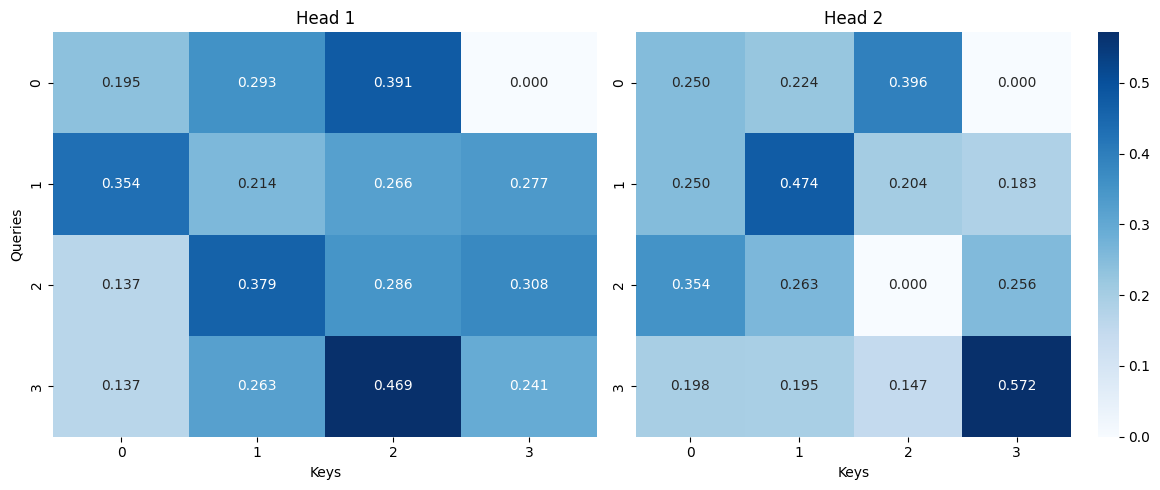


Each head can learn to focus on different types of relationships!


In [30]:
from src.model.attention import MultiHeadAttention

# Create multi-head attention layer
d_model, n_heads = 8, 2
mha = MultiHeadAttention(d_model, n_heads)

print(f"Multi-head attention with {n_heads} heads")
print(f"Model dimension: {d_model}")
print(f"Dimension per head: {d_model // n_heads}")

# Create input
batch_size, seq_len = 1, 4
x = torch.randn(batch_size, seq_len, d_model)

# Apply multi-head attention
output, attention_weights = mha(x, x, x, return_attention=True)

print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"(batch_size, n_heads, seq_len, seq_len)")

# Visualize attention for each head
fig, axes = plt.subplots(1, n_heads, figsize=(12, 5))
if n_heads == 1:
    axes = [axes]

for head in range(n_heads):
    head_attention = attention_weights[0, head].detach().numpy()
    
    sns.heatmap(
        head_attention,
        annot=True, fmt='.3f',
        cmap='Blues',
        ax=axes[head],
        cbar=head == n_heads - 1  # Only show colorbar for last plot
    )
    axes[head].set_title(f'Head {head + 1}')
    axes[head].set_xlabel('Keys')
    if head == 0:
        axes[head].set_ylabel('Queries')

plt.tight_layout()
plt.show()

print("\nEach head can learn to focus on different types of relationships!")

## Summary

In this notebook, we've explored:

1. **Scaled Dot-Product Attention** - The fundamental attention operation
2. **Attention Visualization** - How to interpret attention weights
3. **Causal Attention** - Preventing information leakage in language modeling
4. **Multi-Head Attention** - Parallel attention heads for richer representations

### Key Takeaways:

- Attention allows models to dynamically focus on relevant parts of the input
- The mechanism is based on similarity between queries and keys
- Causal masking is essential for autoregressive language modeling
- Multi-head attention captures different types of relationships
- Attention enables parallelization and handles long-range dependencies

### Next Steps:

In the next notebook, we'll see how attention is combined with other components to build complete transformer blocks!